# **Assignment 2:**

Forecasting models

In [1]:
%load_ext autoreload
%autoreload 2

## The steps are:
1.   Load and explore dataset
2.   Data preparation
3.   Split data
4.   ARIMA model¶
5.   XGBoost model with hyperparamaters¶

## 1. Load and explore dataset

Import packages

In [2]:
import pandas as pd
import numpy as np

Load the dataset into dataframe

In [3]:
df_test = pd.read_csv('../../data/raw/sales_test.csv')
df_train = pd.read_csv('../../data/raw/sales_train.csv')
df_events = pd.read_csv('../../data/raw/calendar_events.csv')
df_calendar = pd.read_csv('../../data/raw/calendar.csv')
df_items_weekly_price = pd.read_csv('../../data/raw/items_weekly_sell_prices.csv')

Display the first 5 rows of tranining data 


In [4]:
df_train.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1532,d_1533,d_1534,d_1535,d_1536,d_1537,d_1538,d_1539,d_1540,d_1541
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,0,1,0,1,0,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,8,2,0,8,2,3,1,1,3,8
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,0,1,3,2,1,1,2,2,3


In [5]:
print("Missing values in tranining data:")
for i in df_train.columns[df_train.isna().any()]:
    no_missing = df_train[i].isna().sum()
    print("Column "+str(i) +":"+str(no_missing) +" NAs")

Missing values in tranining data:


Information of training dataset

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1547 entries, id to d_1541
dtypes: int64(1541), object(6)
memory usage: 359.9+ MB


Showing first 5 rows of calendar 

In [7]:
df_calendar.head(5)

,date,wm_yr_wk,d
0,2011-01-29,11101,d_1
1,2011-01-30,11101,d_2
2,2011-01-31,11101,d_3
3,2011-02-01,11101,d_4
4,2011-02-02,11101,d_5


Showing first 5 rows of event calendar 

In [8]:
df_events.head(5)

,date,event_name,event_type
0,2011-02-06,SuperBowl,Sporting
1,2011-02-14,ValentinesDay,Cultural
2,2011-02-21,PresidentsDay,National
3,2011-03-09,LentStart,Religious
4,2011-03-16,LentWeek2,Religious


Showing first 5 rows of test

In [9]:
df_test.head(5)

,d_1542,d_1543,d_1544,d_1545,d_1546,d_1547,d_1548,d_1549,d_1550,d_1551,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,0,1,0,2,1,0,2,0,1,0,...,2,4,0,0,0,0,3,3,0,1
1,0,0,0,0,0,0,0,0,1,0,...,0,1,2,1,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,4,1,0,1,3,5,2,3,0,2,...,1,1,0,4,0,1,3,0,2,6
4,3,0,0,1,1,0,2,0,2,1,...,0,0,0,2,1,0,0,2,1,0


## 2. Data preparations

Melt the training data

In [10]:
columnns=['id','dept_id','cat_id','state_id']
df_train_melt=pd.melt(df_train.drop(columns=columnns),id_vars=['item_id','store_id'],var_name='day',value_name='sales')

In [11]:
df_train_melt.head(5)

,item_id,store_id,day,sales
0,HOBBIES_1_001,CA_1,d_1,0
1,HOBBIES_1_002,CA_1,d_1,0
2,HOBBIES_1_003,CA_1,d_1,0
3,HOBBIES_1_004,CA_1,d_1,0
4,HOBBIES_1_005,CA_1,d_1,0


Combining calendar and events datasets

In [12]:
df_ce = pd.merge(df_calendar, df_events, on='date', how='left')

In [13]:
#drop the event name
df_ce.drop(columns="event_name",inplace=True)

In [14]:
#Rename day
df_ce.rename(columns={'d':'day'},inplace=True)

df_ce.head(5)

One date can have multiple events

In [15]:
print(df_ce[df_ce.duplicated('day')])

            date  wm_yr_wk     day event_type
86    2011-04-24     11113    d_86  Religious
829   2013-05-05     11315   d_828  Religious
1180  2014-04-20     11412  d_1178  Religious
1237  2014-06-15     11420  d_1234   Sporting
1973  2016-06-19     11621  d_1969   Sporting


In [16]:
df_ce[df_ce["day"]=="d_86"]

,date,wm_yr_wk,day,event_type
85,2011-04-24,11113,d_86,Cultural
86,2011-04-24,11113,d_86,Religious


Combine the malted dataset vs combined calendar and event.

In [17]:
df_train_ce = pd.merge(df_train_melt, df_ce, on='day', how='left')

Combine with items weekly price

In [18]:
df_train_combined = pd.merge(df_train_ce, df_items_weekly_price, on=['item_id','store_id','wm_yr_wk'], how='left')

In [19]:
df_train_combined.head(5)

,item_id,store_id,day,sales,date,wm_yr_wk,event_type,sell_price
0,HOBBIES_1_001,CA_1,d_1,0,2011-01-29,11101,NaN,NaN
1,HOBBIES_1_002,CA_1,d_1,0,2011-01-29,11101,NaN,NaN
2,HOBBIES_1_003,CA_1,d_1,0,2011-01-29,11101,NaN,NaN
3,HOBBIES_1_004,CA_1,d_1,0,2011-01-29,11101,NaN,NaN
4,HOBBIES_1_005,CA_1,d_1,0,2011-01-29,11101,NaN,NaN


Missing records:

In [20]:
print("Missing values in tranining data:")
for i in df_train_combined.columns[df_train_combined.isna().any()]:
    no_missing = df_train_combined[i].isna().sum()
    print("Column "+str(i) +":"+str(no_missing) +" NAs")

Missing values in tranining data:
Column event_type:43143350 NAs
Column sell_price:12291876 NAs


Fill null values in weekly sell price with average prices of the same item in different stores 

In [21]:
mean_price = df_train_combined.groupby(['item_id'])['sell_price'].transform('mean')

In [22]:
df_train_combined['sell_price'].fillna(mean_price, inplace=True)

Create a revanue column by using sales and sell_price

In [23]:
df_train_combined["revenue"]=df_train_combined["sales"]*df_train_combined["sell_price"]

Create a event columns to check if is there event on this day

In [24]:
df_train_combined['is_event'] = df_train_combined['event_type'].notnull().astype(int)

Drop sale, day, wm_yr_wk,sell_price, event_type columns

In [25]:
df_train_combined.drop(columns=["item_id","store_id","day","event_type","sales","wm_yr_wk","sell_price"],inplace=True)

Convert date to timestampe and then group date

In [26]:
df_train_combined['date'] = pd.to_datetime(df_train_combined['date'])

In [72]:
df_train_grouped = df_train_combined.groupby('date').agg({'revenue': 'sum', 'is_event': 'max'}).reset_index()
df_train_grouped

,date,revenue,is_event
0,2011-01-29,81650.61,0
1,2011-01-30,78970.57,0
2,2011-01-31,57706.91,0
3,2011-02-01,60761.20,0
4,2011-02-02,46959.95,0
...,...,...,...
1536,2015-04-14,102896.92,0
1537,2015-04-15,106913.88,0
1538,2015-04-16,98373.49,0
1539,2015-04-17,103030.58,0


In [ ]:
!pip install matplotlib

<Axes: >

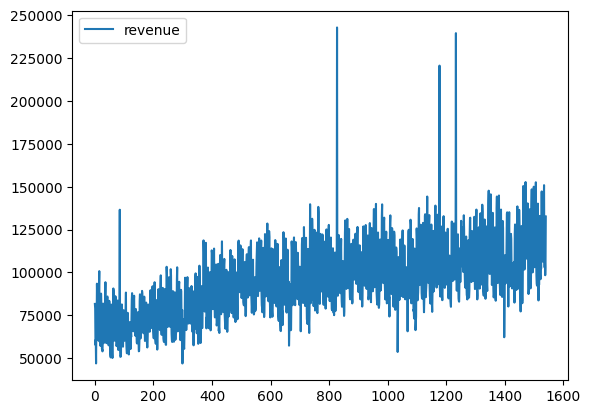

In [54]:
import matplotlib.pyplot as plt
df_train_grouped.drop(columns='is_event').plot()


In [73]:
df_train_grouped[df_train_grouped['revenue'] <1000]

,date,revenue,is_event
330,2011-12-25,23.68,1
696,2012-12-25,24.73,1
1061,2013-12-25,34.32,1
1426,2014-12-25,37.86,1


In [74]:
mean_event=df_train_grouped[df_train_grouped['is_event']==1]['revenue'].mean()
mean_event

92071.696984127

Replace very small revenues with average revenue for event day

In [76]:
df_train_grouped.loc[df_train_grouped['revenue'] < 1000, 'revenue'] = mean_event

## 3. Data Splitting

In [149]:
df_cleaned = df_train_grouped.copy()
df_cleaned = df_cleaned.set_index('date')

In [150]:
#Spliting dataset to training and validating dataset with ratio 8:2

In [151]:
index = int(len(df_cleaned) * 0.8)
train_data = df_cleaned.iloc[:index]
valid_data = df_cleaned.iloc[index:]

In [152]:
train_data.shape

(1232, 2)

In [153]:
valid_data.shape

(309, 2)

<Axes: xlabel='date'>

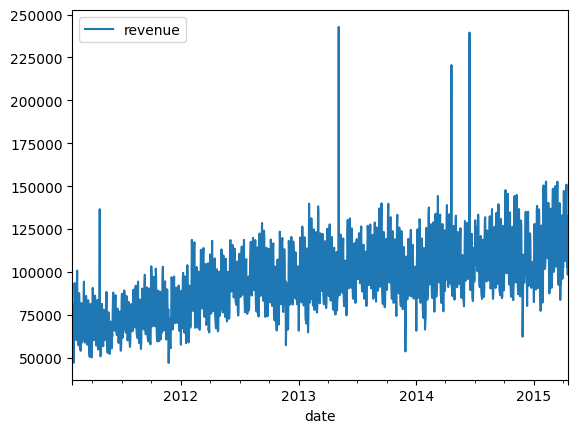

In [83]:
import matplotlib.pyplot as plt
df_cleaned.drop(columns='is_event').plot()


## 4. ARIMA model

In [129]:
import warnings
warnings.filterwarnings("ignore")

In [142]:
!pip install statsmodels,xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 274.4 kB/s eta 0:00:00 kB/s eta 0:00:01:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 1.1 MB/s eta 0:00:00m eta 0:00:010:01:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.1/368.1 kB 997.2 kB/s eta 0:00:001.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 830.0 kB/s eta 0:00:0031m1.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 513.7 kB/s eta 0:00:00m eta 0:00:010:00:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.5/195.5 kB 798.8 kB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 459.3 kB/s eta 0:00:00 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 401.9 kB/s eta 0:00:00 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 654.9 kB/s eta 0:00:00 kB/s eta 0:00:01
  error: subprocess-exited-with-error
  
  × python setup

In [130]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [131]:
ARIMA_model = ARIMA(train_data["revenue"], order=(1,1,1))
ARIMA_fit = ARIMA_model.fit()

In [132]:
# Forecast on the validating set
forecast_steps = len(valid_data)
forecast = ARIMA_fit.forecast(steps=forecast_steps)

In [133]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(valid_data['revenue'], forecast))
print(f'RMSE: {rmse}')

RMSE: 19802.294567363333


## 5. Seasonal Autoregressive Integrated Moving Average (SARIMA) model with grid search

<Axes: xlabel='date'>

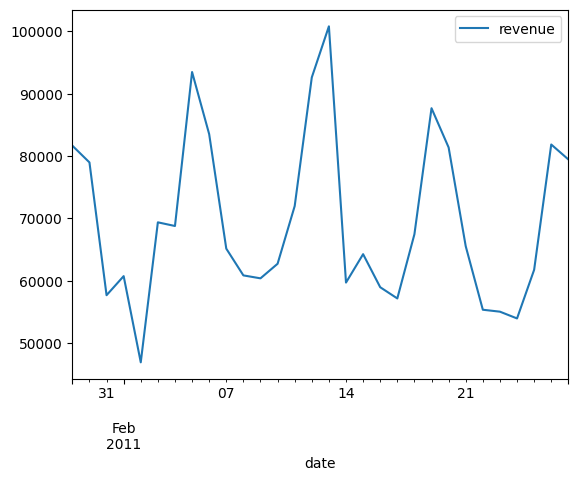

In [161]:
train_data.drop(columns='is_event').head(30).plot()

In [158]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

for i in range(2, 10):
    SARIMAX_model = SARIMAX(train_data['revenue'], order=(1, 1, 1), seasonal_order=(1, 1, 1, i))
    SARIMAX_fit = SARIMAX_model.fit(disp=False)
    forecast_steps = len(valid_data)
    forecast = SARIMAX_fit.forecast(steps=forecast_steps)
    rmse = np.sqrt(mean_squared_error(valid_data['revenue'], forecast))
    print(f'Season days: {i} with RMSE score: {rmse}')

Season days: 2 with RMSE score: 19144.396380456186
Season days: 3 with RMSE score: 19327.06675727978
Season days: 4 with RMSE score: 19092.486185845428
Season days: 5 with RMSE score: 19361.572557600608
Season days: 6 with RMSE score: 19241.12658332435
Season days: 7 with RMSE score: 15213.576470034359
Season days: 8 with RMSE score: 19119.294461503552
Season days: 9 with RMSE score: 20354.132437891833


In [162]:
SARIMAX_model = SARIMAX(train_data['revenue'], order=(1, 1, 1), seasonal_order=(1, 1, 1,7))
SARIMAX_fit = SARIMAX_model.fit(disp=False)
from joblib import dump
dump(SARIMAX_fit,'../../models/forecasting/SARIMAX.joblib')

['../../models/forecasting/SARIMAX.joblib']

In [163]:
forecast_steps = len(valid_data)
forecast = SARIMAX_fit.forecast(steps=forecast_steps)
rmse = np.sqrt(mean_squared_error(valid_data['revenue'], forecast))
print(f'RMSE score: {rmse}')
forecast

RMSE score: 15213.576470034359


2014-06-14    130275.157745
2014-06-15    135332.825193
2014-06-16    105506.731020
2014-06-17     98052.358425
2014-06-18     96499.598113
                  ...      
2015-04-14    114279.489475
2015-04-15    112676.251064
2015-04-16    113744.912441
2015-04-17    124247.120583
2015-04-18    146876.144457
Freq: D, Name: predicted_mean, Length: 309, dtype: float64

## 6. XGBoost model with optimal hyperparamaters

In [41]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

df_cleaned = df_train_grouped.copy()
df_cleaned['day_of_month'] = df_cleaned['date'].dt.day
df_cleaned['month_of_year'] = df_cleaned['date'].dt.month
df_cleaned['day_of_week'] = df_cleaned['date'].dt.dayofweek


#Spliting data again
index = int(len(df_cleaned) * 0.8)
train_data = df_cleaned.drop(columns=['date','is_event']).iloc[:index]
valid_data = df_cleaned.drop(columns=['date','is_event']).iloc[index:]

#Fit model
XGB = XGBRegressor(n_estimators=100, learning_rate=0.04, max_depth=2,random_state=42)
X_train = train_data.drop('revenue', axis=1)
y_train = train_data['revenue']
XGB_lag_fit=XGB.fit(X_train, y_train)

#Predict validate data
X_val = valid_data.drop('revenue', axis=1)
y_val = valid_data['revenue']
y_preds = XGB_lag_fit.predict(X_val)

#Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_preds))
print(f'RMSE: {rmse}')


RMSE: 22325.09309202031
